In [1]:
import numpy as np
import matplotlib.pyplot as plt
import PIL
import pydicom

# 1. DICOM File Handling

## 1.1. Parsing the files

In [2]:
import os
def collect_files(directory : str) -> list :
    ''' Collects the files in a directory and compiles 
    them into a list for further processing. 
    
    Returns a list of files
    '''

    files = []
    for entry in os.listdir(directory) :
        try:
            files.append(entry)
        except Exception as e:
            return str(e)  #investigating the problems in appending the files to the list

    return files

files = collect_files("Images_Data_science_intern")
files

['R4.rvg',
 'IS20250218_193621_8940_10081171.dcm',
 '.ipynb_checkpoints',
 'IS20250115_171841_9465_61003253.dcm',
 'Reference_Output_Quality.jpg',
 'IS20250218_193552_3393_78829426.dcm',
 'R9.rvg',
 'IS20250115_191316_7227_10120577.dcm',
 'R5.rvg',
 'IS20250116_180218_7445_56958340.dcm',
 'IS20250221_192657_5718_56712676.dcm',
 'R6.rvg',
 'R7.rvg',
 'R10.rvg',
 'IS20250115_190348_9148_86297118.dcm']

## 1.2. Preprocessing and handling the files

In [3]:
def format_check(file_name : str) -> bool :
    '''
    This function checks for the validity of the file formats,
    i.e., whether they are DICOM/RVG or not.

    Returns True or False for a given file
    '''
    
    file = tuple(file_name.split("."))
    if file[1] == "dcm" or file[1] == "rvg" :
        return True
    else:
        return False  

for x in files :
    print (x + ' : ' , format_check(x))

R4.rvg :  True
IS20250218_193621_8940_10081171.dcm :  True
.ipynb_checkpoints :  False
IS20250115_171841_9465_61003253.dcm :  True
Reference_Output_Quality.jpg :  False
IS20250218_193552_3393_78829426.dcm :  True
R9.rvg :  True
IS20250115_191316_7227_10120577.dcm :  True
R5.rvg :  True
IS20250116_180218_7445_56958340.dcm :  True
IS20250221_192657_5718_56712676.dcm :  True
R6.rvg :  True
R7.rvg :  True
R10.rvg :  True
IS20250115_190348_9148_86297118.dcm :  True


In [4]:
image = pydicom.dcmread("Images_Data_science_intern/" + files[1])
image

Dataset.file_meta -------------------------------
(0002,0000) File Meta Information Group Length  UL: 198
(0002,0001) File Meta Information Version       OB: b'\x00\x01'
(0002,0002) Media Storage SOP Class UID         UI: 1.2.276.0.7230010.3.1.0.1
(0002,0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.345000512.4304.1739887581.718
(0002,0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002,0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002,0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008,0020) Study Date                          DA: '20250218'
(0008,0021) Series Date                         DA: '20250218'
(0008,0030) Study Time                          TM: '193621'
(0008,0031) Series Time                         TM: '193621'
(0008,0060) Modality                            CS: 'IO'
(0008,0070) Manufacturer                        LO: 'EWOOSOFT'


In [5]:
print(image.PatientName , image.PatientID)

 naglaxmi 20250209_111652


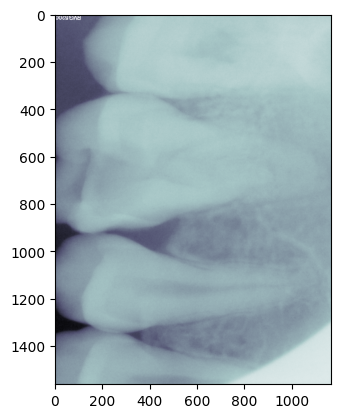

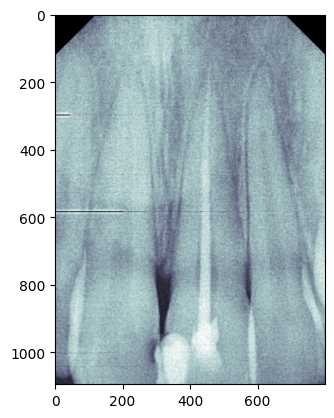

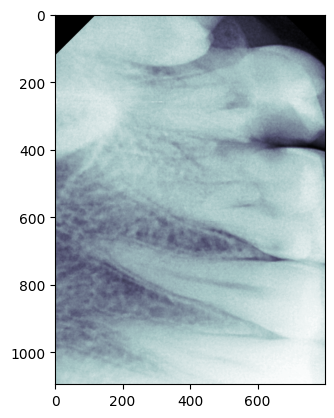

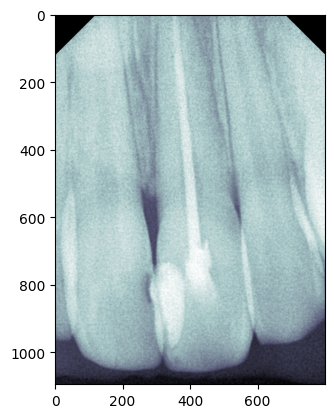

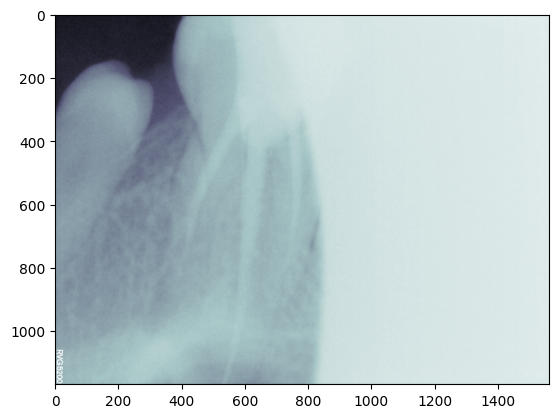

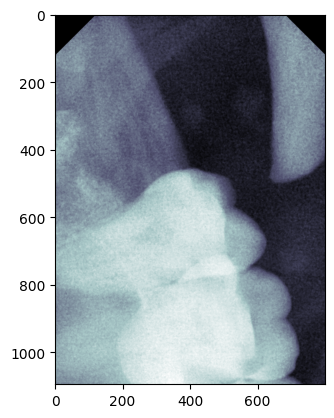

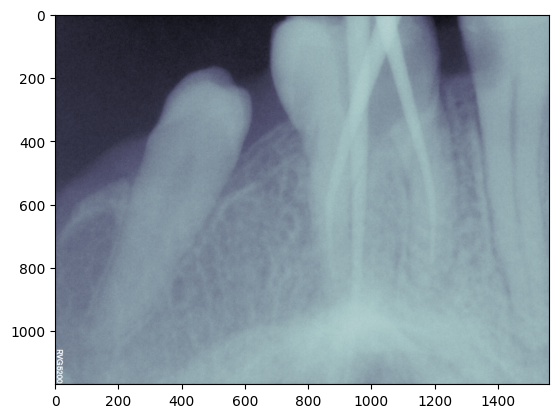

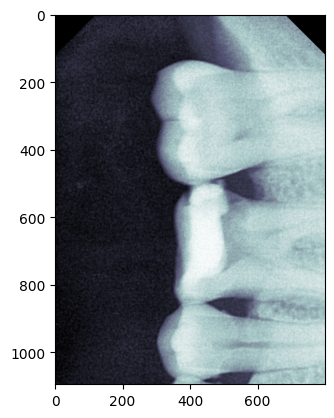

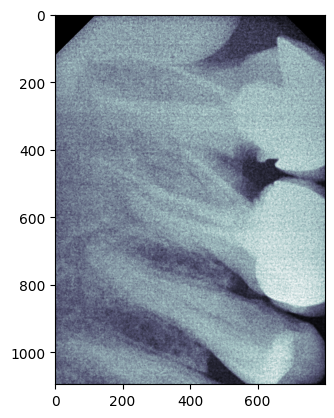

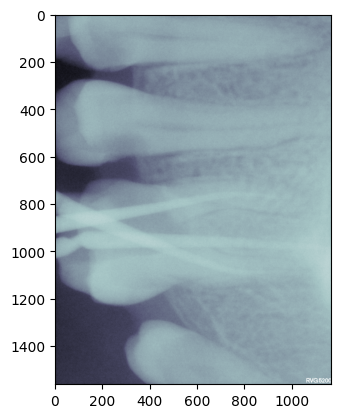

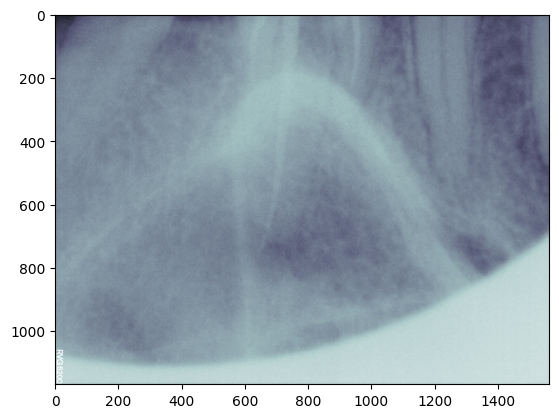

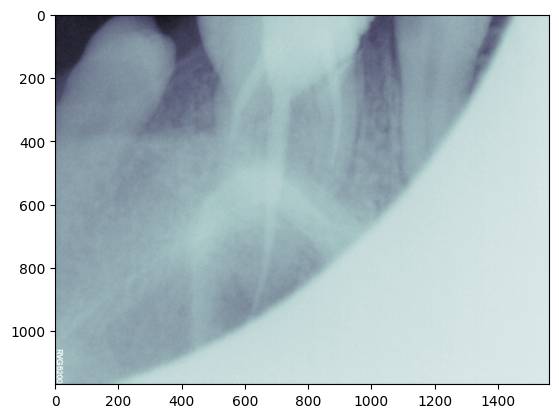

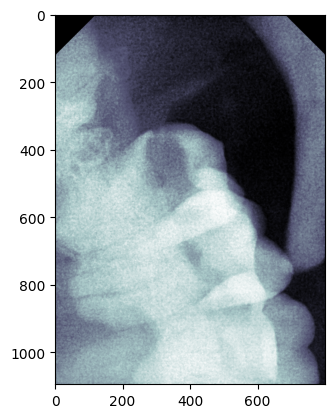

In [6]:
#visualising each of the images at once before applying any preprocessing

for i , file in enumerate(files) :
    if format_check(file) :
        image = pydicom.dcmread("Images_Data_science_intern/" + file)
        arr = image.pixel_array
        plt.imshow(arr , cmap=plt.cm.bone)
        plt.show()
    else:
        continue

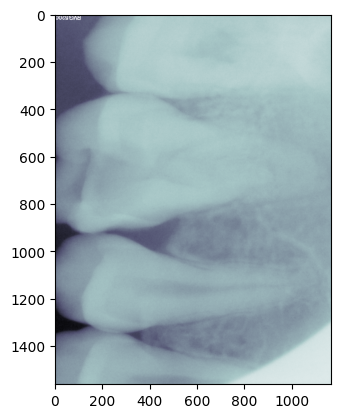

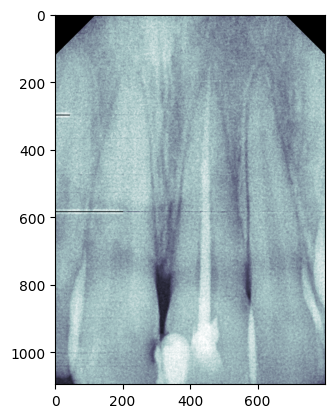

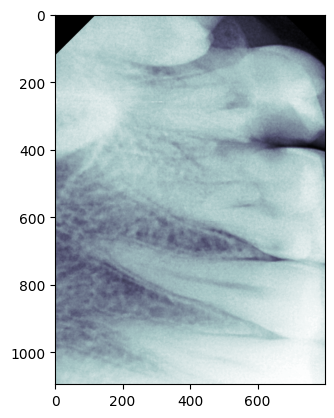

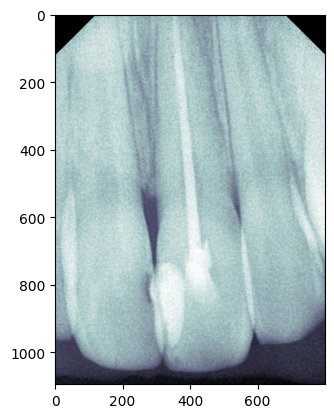

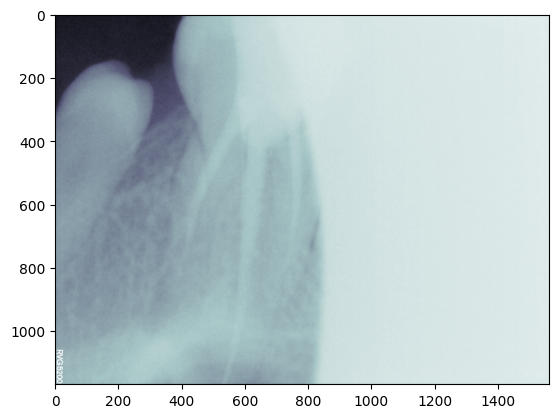

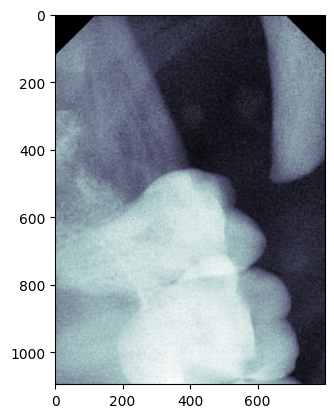

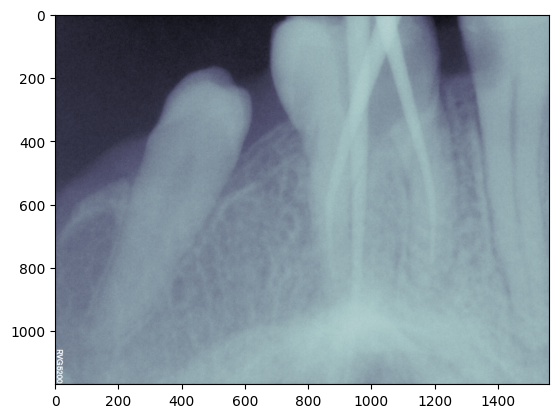

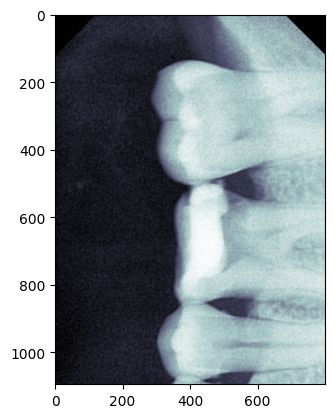

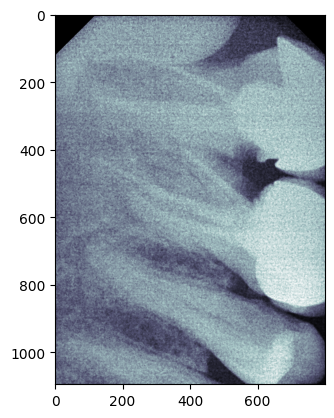

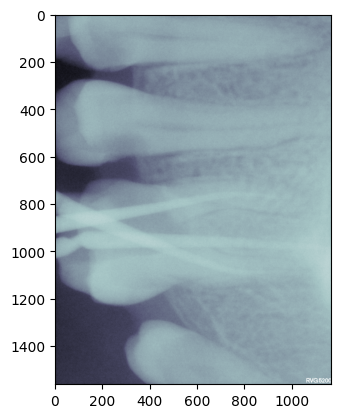

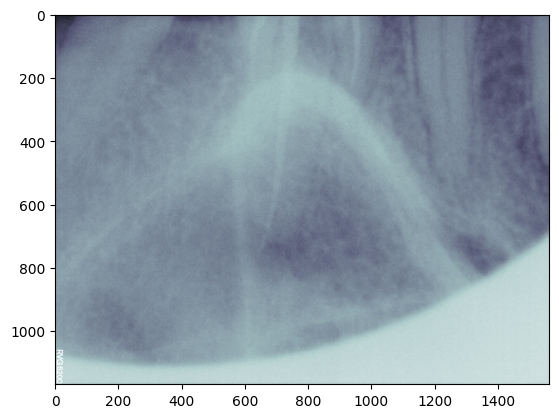

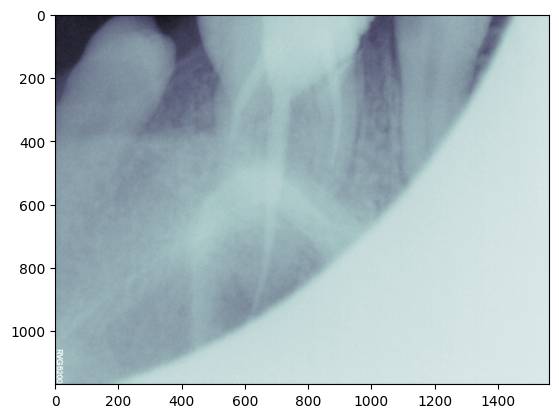

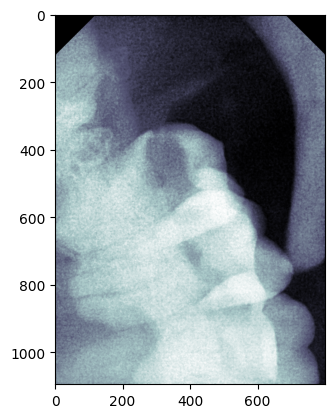

In [7]:
'''
Now that all the images have been parsed successfully, we shall
implement a pipeline to enhance the image quality for better visual
details by applying Modality LUT and VOI LUT in succession.
'''
from pydicom.pixel_data_handlers.util import apply_modality_lut , apply_voi_lut

for i , file in enumerate(files) :
    if format_check(file) :
        image = pydicom.dcmread("Images_Data_science_intern/" + file)
        arr = apply_modality_lut(image.pixel_array , image)
        arr = apply_voi_lut(arr, image)
        plt.imshow(arr , cmap=plt.cm.bone)
        plt.show()
    else:
        continue

## 1.3. Putting Everything Together and Saving the Files

In [8]:
from PIL import Image
from pydicom.pixel_data_handlers.util import apply_modality_lut , apply_voi_lut

def dicom_to_tiff(dcm_path : str , tiff_path : str , apply_modality : bool , apply_voi : bool) -> None :
    '''
    This function serves to read the dcm/rvg files, apply LUT if
    specified and convert the files to tiff for further analysis.
    TIFF format serves as a lossless conversion of the files.

    The function does not return anything.
    '''

    # 1. Read DICOM
    ds = pydicom.dcmread(dcm_path)

    # 2. Get raw pixel data
    arr = ds.pixel_array

    # 3. Apply modality LUT to physical units
    if apply_modality:
        arr = apply_modality_lut(arr, ds)

    # 4. Apply VOI LUT to window/level
    if apply_voi and hasattr(ds, 'WindowWidth'):
        arr = apply_voi_lut(arr, ds)

    # 5. Normalise/scale to desired bit‐depth
    #    For 16-bit TIFF, map the data’s min/max to [0, 65535]:
    arr = arr.astype(np.float32)
    arr -= arr.min()
    arr /= arr.max()
    arr16 = (arr * 65535).astype(np.uint16)

    # 6. Save as TIFF
    img = Image.fromarray(arr16)
    img.save(tiff_path, format='TIFF')

In [9]:
#applying the conversion to the files

for file in files:
    output = '' #to store the output name of the new files
    if format_check(file) :  #check whether the file is in .dc or .rvg format
        if ".dcm" in file :
            output = file.replace('.dcm', '.tiff')
        elif ".rvg" in file :
            output = file.replace('.rvg', '.tiff')
        else:
            print("error converting file type: " , file)
            break
    
        dicom_to_tiff("Images_Data_science_intern/" + file , "saved_images/" + output , True , True)
        print("successfully: " , file , "       converted to: " , output) #checking for successful conversion

    else:
        print("error filetype: " , file) #prints all the filetypes that are not .dcm or .rvg

successfully:  R4.rvg        converted to:  R4.tiff
successfully:  IS20250218_193621_8940_10081171.dcm        converted to:  IS20250218_193621_8940_10081171.tiff
error filetype:  .ipynb_checkpoints
successfully:  IS20250115_171841_9465_61003253.dcm        converted to:  IS20250115_171841_9465_61003253.tiff
error filetype:  Reference_Output_Quality.jpg
successfully:  IS20250218_193552_3393_78829426.dcm        converted to:  IS20250218_193552_3393_78829426.tiff
successfully:  R9.rvg        converted to:  R9.tiff
successfully:  IS20250115_191316_7227_10120577.dcm        converted to:  IS20250115_191316_7227_10120577.tiff
successfully:  R5.rvg        converted to:  R5.tiff
successfully:  IS20250116_180218_7445_56958340.dcm        converted to:  IS20250116_180218_7445_56958340.tiff
successfully:  IS20250221_192657_5718_56712676.dcm        converted to:  IS20250221_192657_5718_56712676.tiff
successfully:  R6.rvg        converted to:  R6.tiff
successfully:  R7.rvg        converted to:  R7.tif

In [10]:
#checking the contents of saved_images directory
collect_files("saved_images")

['IS20250115_191316_7227_10120577.tiff',
 'R7.tiff',
 'R4.tiff',
 'IS20250221_192657_5718_56712676.tiff',
 'R9.tiff',
 'IS20250116_180218_7445_56958340.tiff',
 'IS20250115_171841_9465_61003253.tiff',
 'R6.tiff',
 'IS20250218_193552_3393_78829426.tiff',
 'R5.tiff',
 'IS20250115_190348_9148_86297118.tiff',
 'IS20250218_193621_8940_10081171.tiff',
 'R10.tiff']

# 2. Characterising the Images

In [11]:
import cv2

images = collect_files("saved_images")
images

['IS20250115_191316_7227_10120577.tiff',
 'R7.tiff',
 'R4.tiff',
 'IS20250221_192657_5718_56712676.tiff',
 'R9.tiff',
 'IS20250116_180218_7445_56958340.tiff',
 'IS20250115_171841_9465_61003253.tiff',
 'R6.tiff',
 'IS20250218_193552_3393_78829426.tiff',
 'R5.tiff',
 'IS20250115_190348_9148_86297118.tiff',
 'IS20250218_193621_8940_10081171.tiff',
 'R10.tiff']

In [12]:
img = list()

for file in images :
    img.append(cv2.imread("saved_images/" + file))

img

[array([[[255, 255, 255],
         [255, 255, 255],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],
 
        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],
 
        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],
 
        ...,
 
        [[106, 106, 106],
         [122, 122, 122],
         [133, 133, 133],
         ...,
         [ 45,  45,  45],
         [ 45,  45,  45],
         [ 59,  59,  59]],
 
        [[120, 120, 120],
         [122, 122, 122],
         [130, 130, 130],
         ...,
         [ 44,  44,  44],
         [ 45,  45,  45],
         [ 48,  48,  48]],
 
        [[139, 139, 139],
         [134, 134, 134],
         [122, 122, 122],
         ...,
         [ 44,  44,  44],
  

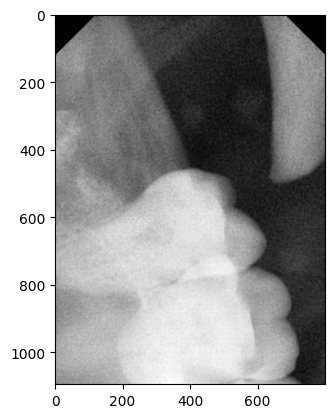

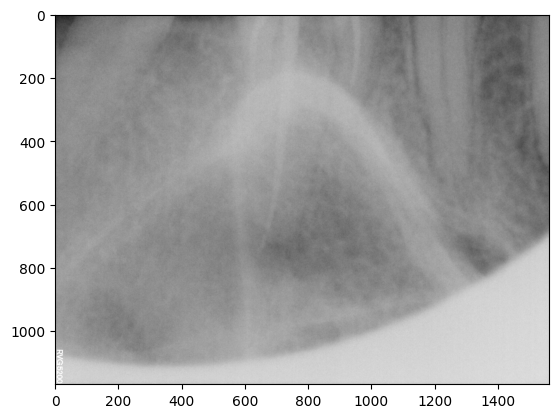

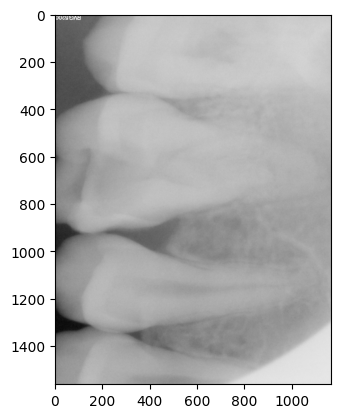

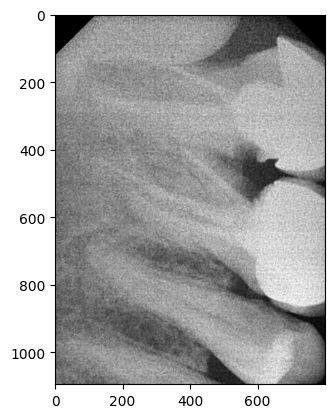

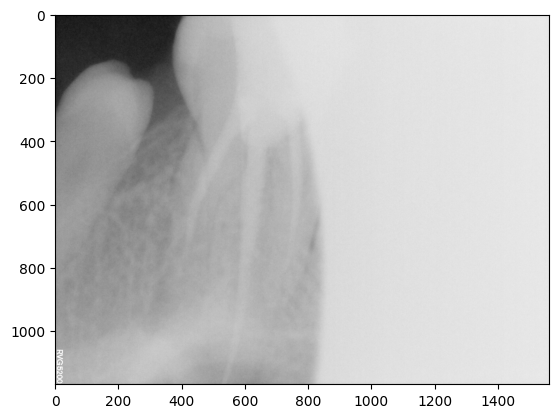

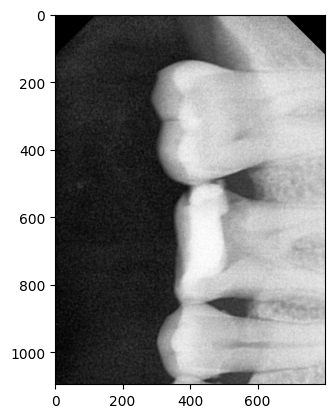

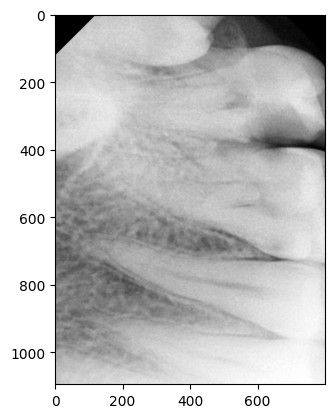

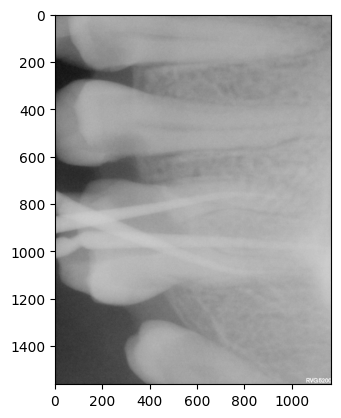

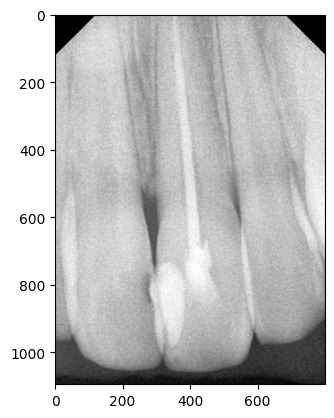

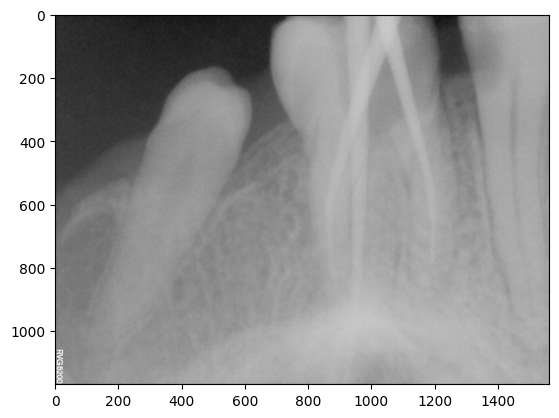

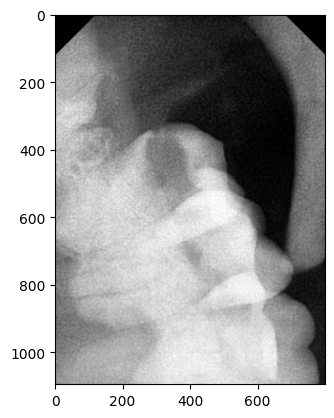

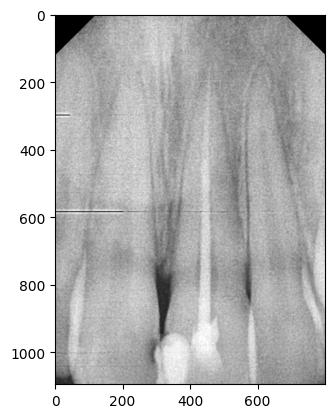

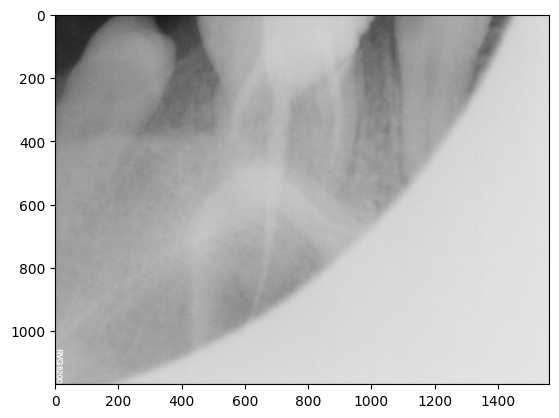

In [13]:
for image in img :
    plt.imshow(image , cmap=plt.cm.bone)
    plt.show()

## 2.1. Quantifying the Brightness

In [14]:
brightness = dict()

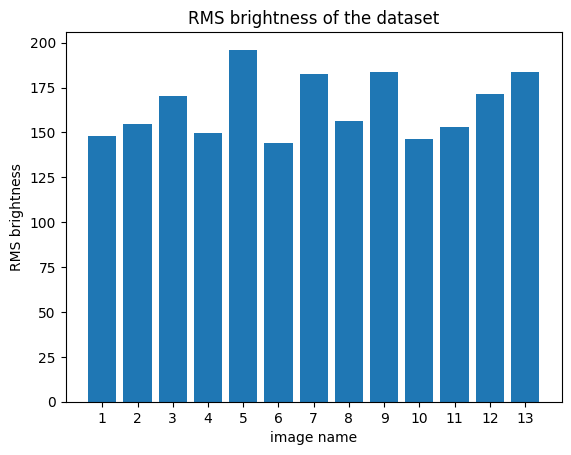

In [48]:
# This cell implements the simple RMS brightness of the images
brightness["RMS"] = [] #creating a key in the dictionary
brights = [] #to store means for each of the images

for i in range(len(img)) :
    brights.append((images[i] , np.sqrt(np.mean(img[i].astype(float)**2))))

brightness["RMS"].append(brights)
#print(brightness["RMS"])

plt.bar(["1" , "2" , "3" , "4" , "5" , "6" , "7" , "8" , "9" , "10" , "11" , "12" , "13"] , [t[1] for t in brights])
plt.ylabel("RMS brightness")
plt.xlabel("image name")
plt.title("RMS brightness of the dataset")
plt.show()

In [49]:
def histogram_centre_of_mass(img: np.ndarray, num_bins: int = 256) -> float:
    """
    Compute the histogram centre of mass (COM) of a grayscale image.
    
    Parameters:
    img : np.ndarray
        nD array of pixel intensities, assumed in the range [0, 255].
    num_bins : int
        Number of bins for the histogram (default 256).
        
    Returns:
    float
        Centre of mass of the histogram, in the same intensity units [0–255].
    """
    # 1) Compute histogram and bin edges
    hist, bin_edges = np.histogram(img.ravel(),
                                   bins=num_bins,
                                   range=(0, 255),
                                   density=False)
    
    # 2) Compute bin centres from edges
    bin_centres = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # 3) Compute center of mass: sum(intensity * count) / sum(count)
    com = (bin_centres * hist).sum() / hist.sum()
    return com

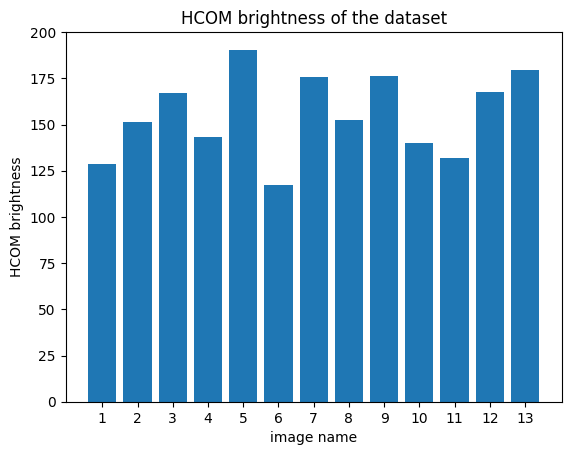

In [50]:
# This cell implements Histogram Centre of Mass (HCOM) for each of the images
brightness["HCOM"] = [] #creating a key in the dictionary
brights = [] #to store the HCOM for each of the images

for i in range(len(img)) :
    brights.append((images[i] , histogram_centre_of_mass(img[i])))

brightness["HCOM"].append(brights)
#print(brightness["HCOM"])

plt.bar(["1" , "2" , "3" , "4" , "5" , "6" , "7" , "8" , "9" , "10" , "11" , "12" , "13"] , [t[1] for t in brights])
plt.ylabel("HCOM brightness")
plt.xlabel("image name")
plt.title("HCOM brightness of the dataset")
plt.show()

## 2.2. Quantifying the Contrast

In [24]:
contrast = dict()

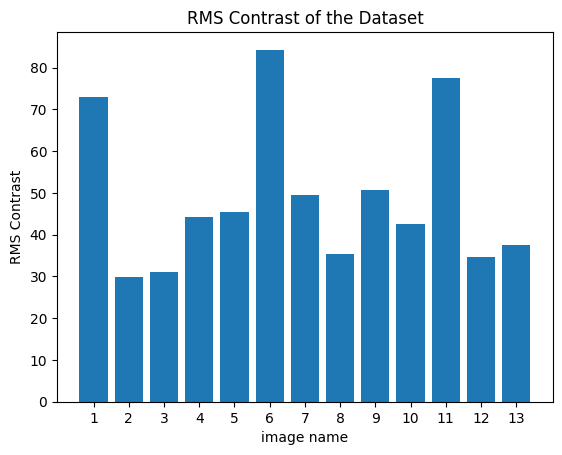

In [51]:
# This cell implements simple RMS contrast for the contrast of each of the images 
contrast["RMS"] = [] #creating a key in the dictionary
contrasts = [] #to store the RMS for each of the images

for i in range(len(img)) :
    contrasts.append((images[i] , np.std(img[i])))

contrast["RMS"].append(contrasts)
#contrast["RMS"]

plt.bar(["1" , "2" , "3" , "4" , "5" , "6" , "7" , "8" , "9" , "10" , "11" , "12" , "13"] , [t[1] for t in contrasts])
plt.ylabel("RMS Contrast")
plt.xlabel("image name")
plt.title("RMS Contrast of the Dataset")
plt.show()

In [52]:
def entropy_contrast(img: np.ndarray, num_bins: int = 256) -> float:
    """
    Compute the entropy-based contrast of a grayscale image.
    
    Parameters:
    img : np.ndarray
        nD array of pixel intensities, assumed in the range [0, 255]. 
        (Previous preprocessing steps ensure this range)
    num_bins : int
        Number of bins to use for the histogram (default 256).
        
    Returns:
    float
        The Shannon entropy of the image histogram (in bits), which
        serves as a global “contrast” measure.
    """
    # Flatten to 1D and compute the normalised histogram (probabilities)
    hist, _ = np.histogram(img.ravel() , bins=num_bins , range=(0, 255) , density=False)
    
    # Convert to the probability distribution
    p = hist / hist.sum()
    
    # Only keep non-zero probabilities to avoid log2(0)
    p = p[p > 0]
    
    # Shannon entropy (base-2)
    H = -1 * np.sum(p * np.log2(p))
    return H


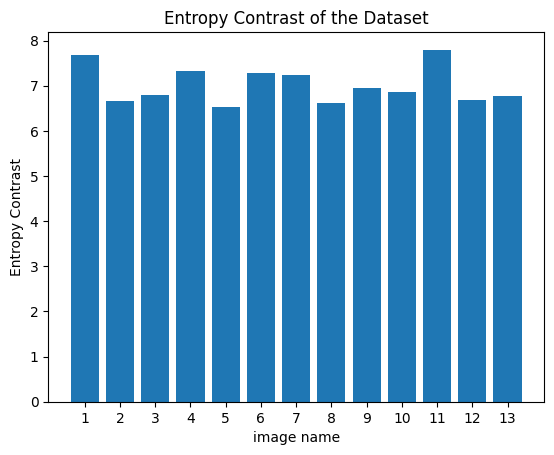

In [53]:
# This cell calculates the entropy contrast for each of the images
contrast["entropy"] = [] #creating a key in the dictionary
contrasts = [] #to store the entropy for each of the images

for i in range(len(img)) :
    contrasts.append((images[i] , entropy_contrast(img[i])))

contrast["entropy"].append(contrasts)
#contrast["entropy"]

plt.bar(["1" , "2" , "3" , "4" , "5" , "6" , "7" , "8" , "9" , "10" , "11" , "12" , "13"] , [t[1] for t in contrasts])
plt.ylabel("Entropy Contrast")
plt.xlabel("image name")
plt.title("Entropy Contrast of the Dataset")
plt.show()

## 2.3. Quantifying the Sharpness

In [28]:
sharpness = dict()

In [54]:
def sharpness_laplacian(img : np.ndarray) -> float :
    '''
    This function computes the second derivative (Laplacian)
    of the images and computes the variance of the laplacian
    to quantify the image brightness.

    Inputs:
    img : a numpy ndarray of the image

    Returns:
    float : the variance of the laplacian
    '''
    
    lap= cv2.Laplacian(img, cv2.CV_64F)
    return lap.var()

def sharpness_tenengrad(img: np.ndarray) -> float:
    '''
    This function computes the Tenengrad sharpness
    of the images using Sobel filters to approximate
    the gradients and summing up their squares and
    taking a mean of it.

    Inputs:
    img : a numpy ndarray of the image

    Returns:
    float: the Tenengrad sharpness of the image
    '''
    
    gx = cv2.Sobel(img, cv2.CV_64F, 1, 0)
    gy = cv2.Sobel(img, cv2.CV_64F, 0, 1)
    fm = gx**2 + gy**2
    return fm.mean()

def sharpness_brenner(img: np.ndarray) -> float:
    '''
    Computes the difference two pixels apart and 
    takes a mean of the square of these differences.

    Inputs:
    img : a numpy ndarray of the image

    Returns:
    float: the Brenner sharpness of the image
    '''
    return np.mean((img[:, 2:] - img[:, :-2])**2)

def sharpness_gradient(img: np.ndarray) -> float:
    '''
    Calculates the gradient using Sobel and takes the
    mean absolute value.

    Input:
    img : a numpy ndarray of the image

    Returns:
    float : the gradient sharpness of the image
    '''
    gx = cv2.Sobel(img, cv2.CV_64F, 1, 0)
    gy = cv2.Sobel(img, cv2.CV_64F, 0, 1)
    grad = np.sqrt(gx*gx + gy*gy)
    return grad.mean()

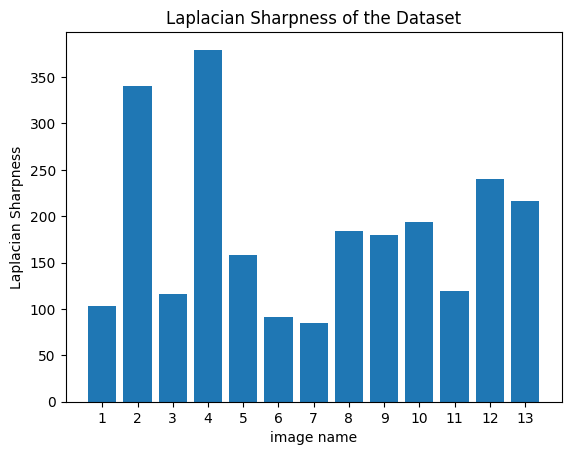

In [55]:
# This cell calculates the Laplacian sharpness of the images
sharpness["laplacian"] = [] #creating a key in the dictionary
sharps = [] #to store the laplacian variance for each of the images

for i in range(len(img)) :
    sharps.append((images[i] , sharpness_laplacian(img[i])))

sharpness["laplacian"].append(sharps)
#sharpness["Laplacian"]

plt.bar(["1" , "2" , "3" , "4" , "5" , "6" , "7" , "8" , "9" , "10" , "11" , "12" , "13"] , [t[1] for t in sharps])
plt.ylabel("Laplacian Sharpness")
plt.xlabel("image name")
plt.title("Laplacian Sharpness of the Dataset")
plt.show()

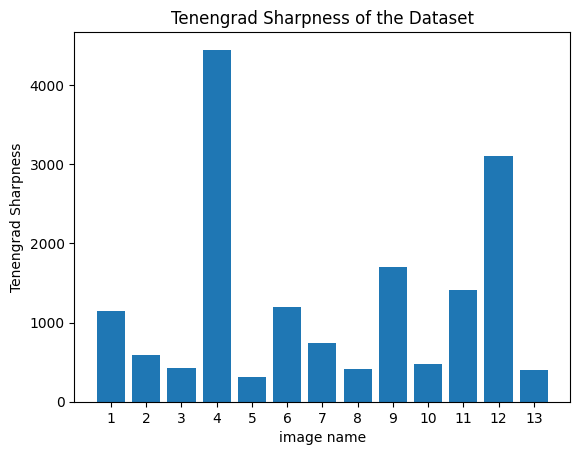

In [56]:
# This cell calculates the Tenengrad sharpness of the images
sharpness["tenengrad"] = [] #creating a key in the dictionary
sharps = [] #to store the tenengrad sharpness for each of the images

for i in range(len(img)) :
    sharps.append((images[i] , sharpness_tenengrad(img[i])))

sharpness["tenengrad"].append(sharps)
#sharpness["tenengrad"]

plt.bar(["1" , "2" , "3" , "4" , "5" , "6" , "7" , "8" , "9" , "10" , "11" , "12" , "13"] , [t[1] for t in sharps])
plt.ylabel("Tenengrad Sharpness")
plt.xlabel("image name")
plt.title("Tenengrad Sharpness of the Dataset")
plt.show()

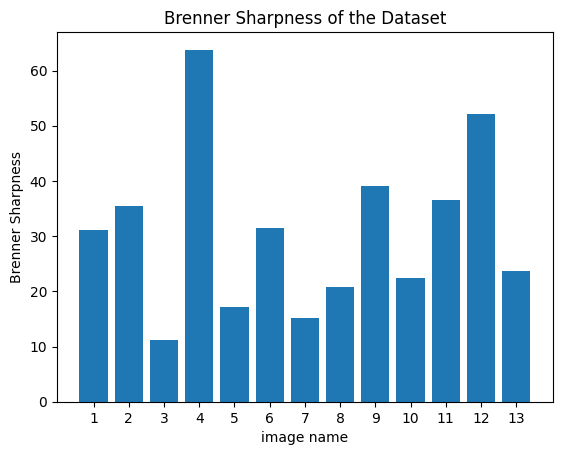

In [57]:
# This cell calculates the Brenner's sharpness of the images
sharpness["brenner"] = [] #creating a key in the dictionary
sharps = [] #to store the brenner's sharpness for each of the images

for i in range(len(img)) :
    sharps.append((images[i] , sharpness_brenner(img[i])))

sharpness["brenner"].append(sharps)
#sharpness["brenner"]

plt.bar(["1" , "2" , "3" , "4" , "5" , "6" , "7" , "8" , "9" , "10" , "11" , "12" , "13"] , [t[1] for t in sharps])
plt.ylabel("Brenner Sharpness")
plt.xlabel("image name")
plt.title("Brenner Sharpness of the Dataset")
plt.show()

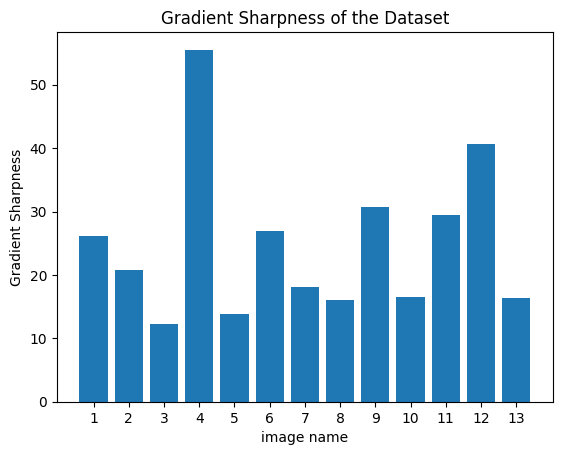

In [58]:
# This cell calculates the gradient sharpness of the images
sharpness["gradient"] = [] #creating a key in the dictionary
sharps = [] #to store the gradient sharpness for each of the images

for i in range(len(img)) :
    sharps.append((images[i] , sharpness_gradient(img[i])))

sharpness["gradient"].append(sharps)
#sharpness["gradient"]

plt.bar(["1" , "2" , "3" , "4" , "5" , "6" , "7" , "8" , "9" , "10" , "11" , "12" , "13"] , [t[1] for t in sharps])
plt.ylabel("Gradient Sharpness")
plt.xlabel("image name")
plt.title("Gradient Sharpness of the Dataset")
plt.show()

## 2.4. Quantifying the Noise

In [34]:
noise = dict()

In [70]:
def gaussian_noise(image: np.ndarray, denoise_func=None) -> float:
    '''
    Estimate Gaussian noise standard deviation by subtracting a denoised version.
    If no denoise_func is provided, uses a simple median filter.
    '''
    
    if denoise_func is None:
        from scipy.ndimage import median_filter
        denoised = median_filter(image, size=3)
    else:
        denoised = denoise_func(image)
    noise = image.astype(float) - denoised.astype(float)
    return noise.std()

def salt_pepper_noise(image: np.ndarray) -> float:
    '''
    Estimate salt-and-pepper noise ratio as fraction of pixels at extremes (0 or 255).
    '''
    
    total = image.size
    num_extremes = np.sum((image == 0) | (image == 255))
    return num_extremes / total

def speckle_noise(image: np.ndarray) -> float:
    '''
    Estimate speckle noise variance assuming multiplicative noise model:
    Var(I) = mean(I)^2 * Var(n), so Var(n) = Var(I) / mean(I)^2.
    '''
    
    img = image.astype(float)
    var = img.var()
    mean = img.mean()
    return var / (mean**2) if mean != 0 else np.nan


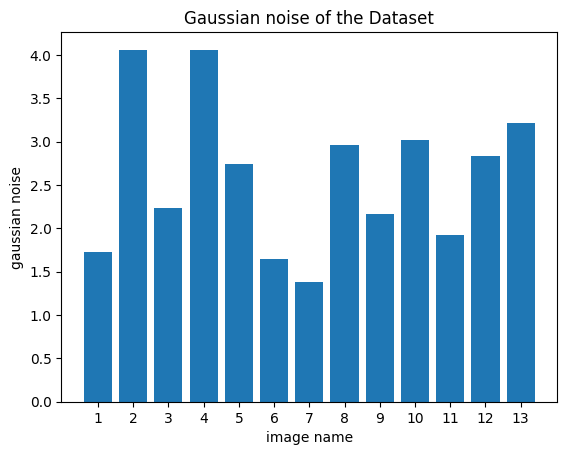

In [71]:
# This cell calculates the gaussian noise of the images
noise["gaussian"] = [] #creating a key in the dictionary
noises = [] #to store the gaussian noise for each of the images

for i in range(len(img)) :
    noises.append((images[i] , gaussian_noise(img[i])))

noise["gaussian"].append(noises)

plt.bar(["1" , "2" , "3" , "4" , "5" , "6" , "7" , "8" , "9" , "10" , "11" , "12" , "13"] , [t[1] for t in noises])
plt.ylabel("gaussian noise")
plt.xlabel("image name")
plt.title("Gaussian noise of the Dataset")
plt.show()

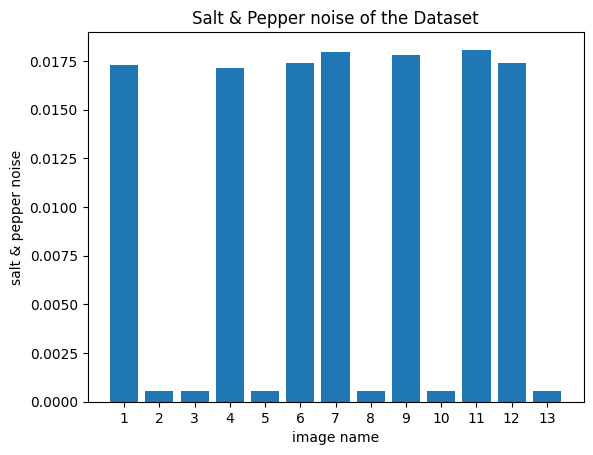

In [72]:
# This cell calculates the salt and papper noise of the images
noise["salpep"] = [] #creating a key in the dictionary
noises = [] #to store the poisson noise for each of the images

for i in range(len(img)) :
    noises.append((images[i] , salt_pepper_noise(img[i])))

noise["salpep"].append(noises)
#print(noise["poisson"])

plt.bar(["1" , "2" , "3" , "4" , "5" , "6" , "7" , "8" , "9" , "10" , "11" , "12" , "13"] , [t[1] for t in noises])
plt.ylabel("salt & pepper noise")
plt.xlabel("image name")
plt.title("Salt & Pepper noise of the Dataset")
plt.show()

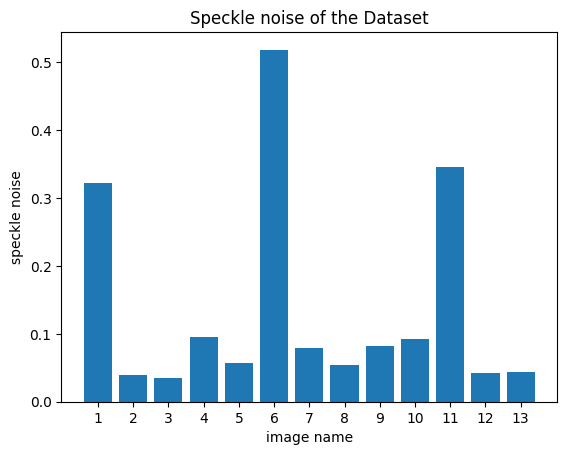

In [73]:
# This cell calculates the speckle noise of the images
noise["speckle"] = [] #creating a key in the dictionary
noises = [] #to store the poisson noise for each of the images

for i in range(len(img)) :
    noises.append((images[i] , speckle_noise(img[i])))

noise["speckle"].append(noises)
#print(noise["poisson"])

plt.bar(["1" , "2" , "3" , "4" , "5" , "6" , "7" , "8" , "9" , "10" , "11" , "12" , "13"] , [t[1] for t in noises])
plt.ylabel("speckle noise")
plt.xlabel("image name")
plt.title("Speckle noise of the Dataset")
plt.show()

# 4. Adaptive Image Pipeline

## 4.1. Algorithm-Based Approach

### 4.1.1. Noise Reduction

In [119]:
def adaptive_noise_reduction(images: list[np.ndarray],
                             gauss_stds: list[float],
                             sp_ratios: list[float],
                             speckle_vars: list[float]) -> list[np.ndarray]:
    '''
    Apply adaptive noise reduction on a list of grayscale images based on estimated noise levels:
      - Salt-and-pepper: adaptive median filtering
      - Gaussian: adaptive Gaussian blurring
      - Speckle: Non-local means denoising

    Parameters:
    images : list of np.ndarray
        List of 2D uint8 grayscale images.
    gauss_stds : list of float
        Estimated Gaussian noise std dev for each image.
    sp_ratios : list of float
        Estimated salt-and-pepper noise ratio for each image.
    speckle_vars : list of float
        Estimated speckle noise variance for each image.

    Returns:
    list of np.ndarray
        Denoised images as uint8 arrays.
    '''
    
    denoised_images = []

    for img, g_std, sp_ratio, sp_var in zip(images, gauss_stds, sp_ratios, speckle_vars):
        # 1) Salt-and-pepper: choose median kernel size (odd integer 3 to 9)
        k_sp = int(np.clip(3 + sp_ratio * 20, 3, 9))
        if k_sp % 2 == 0:
            k_sp += 1
        denoised = cv2.medianBlur(img, k_sp)

        # 2) Gaussian noise: Gaussian blur sigma = estimated std (clamp)
        sigma = max(0.5, g_std)
        # kernel size = 2*int(3*sigma)+1 for adequate support
        k_gauss = 2 * int(3 * sigma) + 1
        denoised = cv2.GaussianBlur(denoised, (k_gauss, k_gauss), sigmaX=sigma)

        # 3) Speckle noise: Non-local Means Denoising
        # h parameter controls filter strength; scale by sqrt(var)
        h = np.sqrt(sp_var) * 10
        denoised = cv2.fastNlMeansDenoising(denoised, None, h, 7, 21)

        denoised_images.append(denoised)

    return denoised_images

In [120]:
gauss_stds = [gaussian_noise(image) for image in img] # calculation of gaussian noises for each of the images
sp_ratios = [salt_pepper_noise(image) for image in img] # calculation of salt and pepper noises for each of the images
speckle_vars = [speckle_noise(image) for image in img] # calculation of specle noises for each of the images

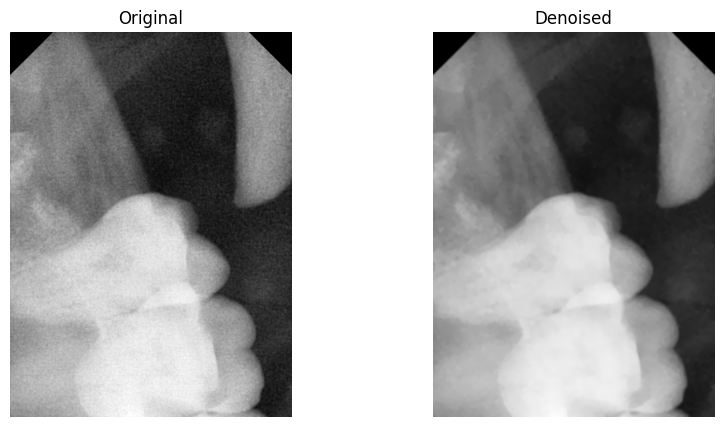

In [121]:
# Example usage:
# Assuming you have lists:
#   dicom_pixel_arrays, gauss_stds, sp_ratios, speckle_vars
denoised = adaptive_noise_reduction(img , gauss_stds , sp_ratios , speckle_vars)

# Display original vs denoised for the first image
# Display comparison for the first image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img[0], cmap='gray')
plt.title('Original')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(denoised[0], cmap='gray')
plt.title('Denoised')
plt.axis('off')
plt.show()

plt.show()

### 4.1.2. Contrast Enhancement

In [122]:
'''
We shall now implement CLAHE contrast enhancement using
the baseline caluculated out of the mean RMS contrast of
the images that was calculated earlier.
'''
def adaptive_clahe(images: list[np.ndarray], contrasts: list[float],
                   base_clip: float = 2.0, tile_grid: tuple[int, int] = (8, 8)):
    '''
    Apply CLAHE with a clip limit adapted to each image's contrast relative to the median baseline.

    Parameters:
    images : list of np.ndarray
        List of 2D grayscale images (any dtype); values will be normalized to 0–255.
    contrasts : list of float
        Per-image contrast values (e.g., histogram-based) of same length as images.
    base_clip : float
        Reference clip limit (default 2.0) to scale from.
    tile_grid : tuple of int
        CLAHE tile grid size.

    Returns:
    list of np.ndarray
        Contrast-enhanced images as uint8 arrays.
    '''
    
    # Compute median baseline
    baseline = np.median(contrasts)
    enhanced_imgs = []

    for img, c in zip(images, contrasts):
        # Normalize to uint8 0–255
        img_norm = cv2.normalize(img.squeeze() , None , 0 , 255 , cv2.NORM_MINMAX).astype(np.uint8)
        img_grey = img_norm

        if img_norm.ndim == 3:
            img_grey = img_norm[..., 0]
            #img_grey = cv2.cvtColor(img_norm, cv2.COLOR_BGR2GRAY)
            
        # Determine adaptive clip limit
        clip_limit = base_clip * (c / baseline)

        # Create CLAHE object and apply
        clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid)
        enhanced = clahe.apply(img_grey)

        enhanced_imgs.append(enhanced)

    return enhanced_imgs

In [123]:
rms_contrasts = [float(t[1]) for t in contrast["RMS"][0]]
rms_contrasts

[72.99133598463595,
 29.95137893614071,
 31.175107165596753,
 44.31780471225219,
 45.45168491764291,
 84.30055932846577,
 49.599767399184095,
 35.4464941197544,
 50.64081300935059,
 42.64466863841404,
 77.42253679103419,
 34.6617315767163,
 37.59818850363864]

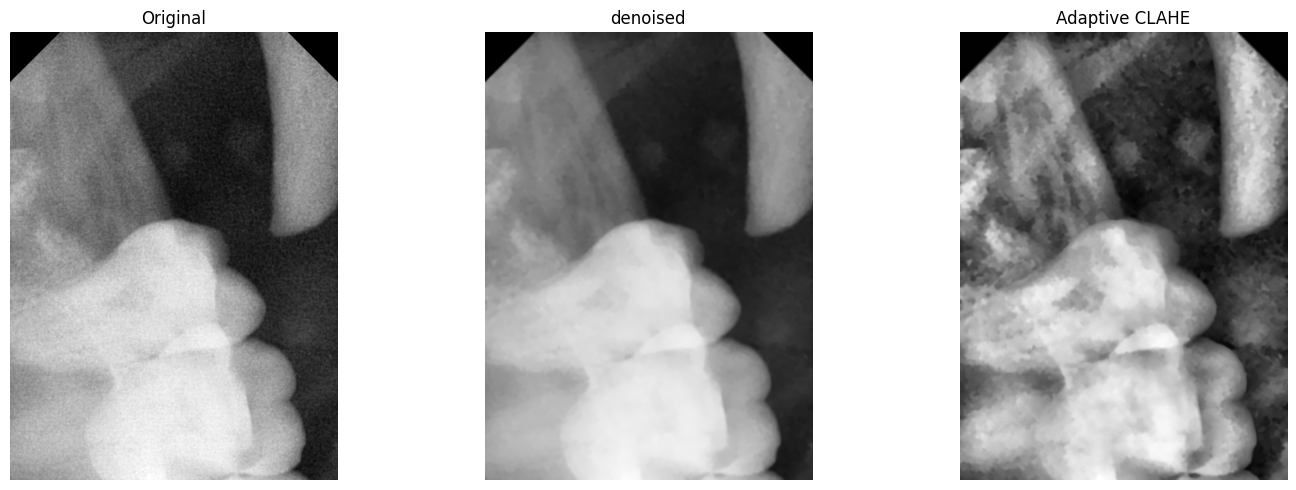

In [124]:
enhanced_images = adaptive_clahe(denoised, rms_contrasts)

# Display comparison for the first image
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(img[0], cmap='gray')
plt.title('Original')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(denoised[0], cmap='gray')
plt.title('denoised')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(enhanced_images[0], cmap='gray')
plt.title('Adaptive CLAHE')
plt.axis('off')

plt.tight_layout()
plt.show()

### 4.1.3. Sharpness Enhancement

In [126]:
def adaptive_sharpen(images: list[np.ndarray],
                     sharpness_vals: list[float],
                     base_strength: float = 1.0,
                     blur_kernel: tuple[int, int] = (5, 5)) -> list[np.ndarray]:
    '''
    Apply adaptive unsharp masking to enhance sharpness based on measured sharpness.
    
    Parameters:
    images : list of np.ndarray
        List of 2D uint8 images (grayscale).
    sharpness_vals : list of float
        Per-image sharpness metrics (variance of Laplacian).
    base_strength : float
        Reference amount of sharpening (multiplied by ratio of baseline to image sharpness).
    blur_kernel : tuple
        Kernel size for Gaussian blur.
    
    Returns:
    list of np.ndarray
        Sharpened images as uint8 arrays.
    '''
    
    # Compute baseline as median of sharpness values
    baseline = np.median(np.array(sharpness_vals, dtype=float))
    sharpened_images = []
    
    for img, s_val in zip(images, sharpness_vals):
        # Calculate adaptive sharpening amount
        if s_val > 0:
            amount = base_strength * (baseline / s_val)
        else:
            amount = base_strength
        
        # Gaussian blur the image
        blurred = cv2.GaussianBlur(img, blur_kernel, 0)
        # Unsharp mask: sharpened = (1 + amount)*img - amount*blurred
        sharpened = cv2.addWeighted(img, 1 + amount, blurred, -amount, 0)
        
        # Clip and convert back to uint8
        sharpened = np.clip(sharpened, 0, 255).astype(np.uint8)
        sharpened_images.append(sharpened)
    
    return sharpened_images

In [133]:
# Compute sharpness for each:
sharp_vals = [sharpness_laplacian(img) for img in enhanced_images]

# Apply adaptive sharpening:
sharpened_images = adaptive_sharpen(enhanced_images, sharp_vals, base_strength=1.0)

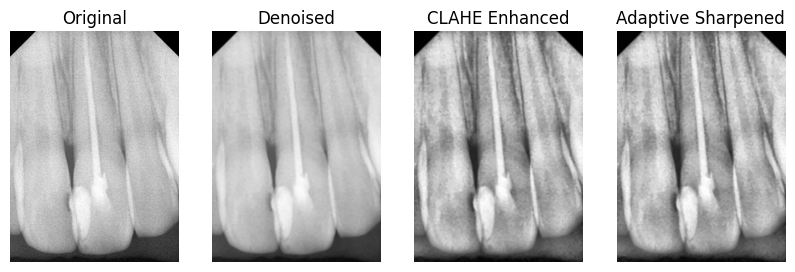

In [137]:
# Display the first original, CLAHE-enhanced, and sharpened images:
plt.figure(figsize=(10, 10))
plt.subplot(1, 4, 1)
plt.imshow(img[8], cmap='gray')
plt.title('Original')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(denoised[8], cmap='gray')
plt.title('Denoised')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(enhanced_images[8], cmap='gray')
plt.title('CLAHE Enhanced')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(sharpened_images[8], cmap='gray')
plt.title('Adaptive Sharpened')
plt.axis('off')

plt.show()

In [139]:
sharpened_images[0].dtype

dtype('uint8')

In [140]:
# saving the images

output_dir = "algo_enhanced_images"
os.makedirs(output_dir, exist_ok=True)

for idx, arr in enumerate(sharpened_images):
    # Convert NumPy array to a PIL Image
    im = Image.fromarray(arr)
    
    # Construct a filename (you can customize this)
    out_path = os.path.join(output_dir, f"final_image_{idx:03d}.tiff")
    
    # Save as TIFF
    im.save(out_path, format="TIFF")
    
    print(f"Saved {out_path}")

Saved algo_enhanced_images/final_image_000.tiff
Saved algo_enhanced_images/final_image_001.tiff
Saved algo_enhanced_images/final_image_002.tiff
Saved algo_enhanced_images/final_image_003.tiff
Saved algo_enhanced_images/final_image_004.tiff
Saved algo_enhanced_images/final_image_005.tiff
Saved algo_enhanced_images/final_image_006.tiff
Saved algo_enhanced_images/final_image_007.tiff
Saved algo_enhanced_images/final_image_008.tiff
Saved algo_enhanced_images/final_image_009.tiff
Saved algo_enhanced_images/final_image_010.tiff
Saved algo_enhanced_images/final_image_011.tiff
Saved algo_enhanced_images/final_image_012.tiff


## 4.2. ML-Based Approach

In [142]:
import glob
import torch
from torch.utils.data import Dataset

In [144]:
'''
Class to load the dataset using the list of file paths
'''

class EnhancementDataset(Dataset):
    def __init__(self, raw_paths, enhanced_paths, transform=None):
        self.raw = raw_paths
        self.enh = enhanced_paths
        self.transform = transform

    def __len__(self):
        return len(self.raw)

    def __getitem__(self, idx):
        raw_arr = load_raw_image(Path(self.raw[idx]))
        enh_arr = load_enhanced_image(Path(self.enh[idx]))
        # normalise to [0,1] and add channel dim
        raw_t = torch.from_numpy(raw_arr[None]/255.).float()
        enh_t = torch.from_numpy(enh_arr[None]/255.).float()
        if self.transform:
            raw_t, enh_t = self.transform(raw_t, enh_t)
        return raw_t, enh_t

In [146]:
raw = collect_files("Images_Data_science_intern")
raw_list = []
enhanced_list = collect_files("algo_enhanced_images")

for file in raw :
    if format_check(file) :
        raw_list.append(file)
    else:
        continue
del raw

print(raw_list)
print(enhanced_list)

['R4.rvg', 'IS20250218_193621_8940_10081171.dcm', 'IS20250115_171841_9465_61003253.dcm', 'IS20250218_193552_3393_78829426.dcm', 'R9.rvg', 'IS20250115_191316_7227_10120577.dcm', 'R5.rvg', 'IS20250116_180218_7445_56958340.dcm', 'IS20250221_192657_5718_56712676.dcm', 'R6.rvg', 'R7.rvg', 'R10.rvg', 'IS20250115_190348_9148_86297118.dcm']
['final_image_005.tiff', 'final_image_008.tiff', 'final_image_003.tiff', 'final_image_007.tiff', 'final_image_010.tiff', 'final_image_012.tiff', 'final_image_000.tiff', 'final_image_009.tiff', 'final_image_011.tiff', 'final_image_004.tiff', 'final_image_001.tiff', 'final_image_006.tiff', 'final_image_002.tiff']


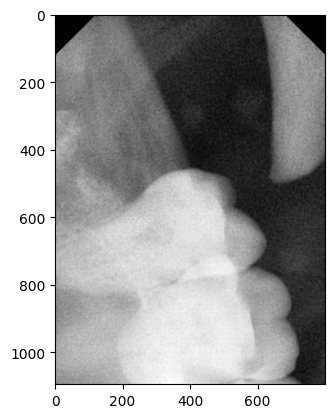

In [147]:
plt.imshow(img[0])
plt.show()

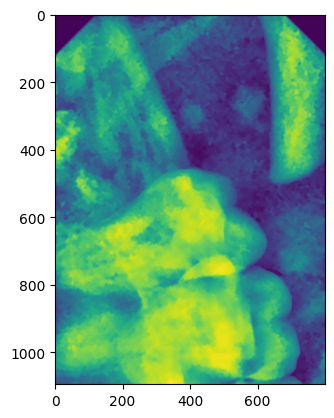

In [149]:
plt.imshow(sharpened_images[0])
plt.show()

In [151]:
def ensure_2d(arr: np.ndarray) -> np.ndarray:
    '''
    Take any numpy array and return a 2D float32 array:
     - squeeze out singleton dims
     - if still >2D, assume last axis is channels or frames:
         * if length is 3 or 4, treat as color channels and average to grayscale
         * otherwise, take the first slice along the last axis
    '''
    
    # 1) remove any size-1 dims
    a = np.squeeze(arr)

    # 2) if already 2D, we’re done
    if a.ndim == 2:
        return a.astype(np.float32)

    # 3) if 3D, decide how to collapse
    if a.ndim == 3:
        # if likely color (3 or 4 channels), average to gray
        if a.shape[2] in (3, 4):
            gray = a.mean(axis=2)
            return gray.astype(np.float32)
        # else assume last axis is frames or depth—pick the first slice
        return a[..., 0].astype(np.float32)

    # 4) higher dims: flatten all but last two dims, then take first “frame”
    #    e.g. (N, H, W) then take first frame; (N, M, H, W) and reshape to (N*M, H, W)
    #    then take the first
    *lead, h, w = a.shape
    nm = int(np.prod(lead))
    a2 = a.reshape(nm, h, w)
    return a2[0].astype(np.float32)


In [154]:
raw_2d = [ensure_2d(x) for x in img]
enh_2d = [ensure_2d(x) for x in sharpened_images]

In [156]:
dataset = EnhancementDataset(raw_2d, enh_2d)
loader  = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=True)

In [157]:
# defining a simple autoencoder for the algorithmically enhanced images as targets

import torch.nn as nn

class SimpleAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        # encoder
        self.enc = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),  # [B,16,H/2,W/2]
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # [B,32,H/4,W/4]
            nn.ReLU(),
        )
        # decoder
        self.dec = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),  # output in [0,1]
        )

    def forward(self, x):
        z = self.enc(x)
        out = self.dec(z)
        return out

model = SimpleAutoencoder().cuda()

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [159]:
torch.cuda.is_available()

False